In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# --------------------------------------------
# 1. Load Dataset
# --------------------------------------------
df_train = pd.read_csv("kdd_train.csv")
df_test = pd.read_csv("kdd_test.csv")

# --------------------------------------------
# 2. Create Binary Label (0 = normal, 1 = attack)
# --------------------------------------------

df_train['attack_binary'] = df_train['labels'].apply(lambda x: 0 if x == 'normal' else 1)
df_test['attack_binary'] = df_test['labels'].apply(lambda x: 0 if x == 'normal' else 1)

# Drop original label column
df_train.drop(['labels'], axis=1, inplace=True)
df_test.drop(['labels'], axis=1, inplace=True)

# --------------------------------------------
# 3. Identify categorical columns
# --------------------------------------------
cat_cols = ['protocol_type', 'service', 'flag']

# --------------------------------------------
# 4. Label Encode categorical columns
# --------------------------------------------
le = LabelEncoder()
for col in cat_cols:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

# --------------------------------------------
# 5. Separate features & labels
# --------------------------------------------
X_train = df_train.drop(['attack_binary'], axis=1)
y_train = df_train['attack_binary']

X_test = df_test.drop(['attack_binary'], axis=1)
y_test = df_test['attack_binary']

# --------------------------------------------
# 6. Impute Missing Values (numeric = mean)
# --------------------------------------------
imputer = SimpleImputer(strategy='mean')

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# --------------------------------------------
# 7. Feature Scaling
# --------------------------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------------------------
# 8. Apply SMOTE to handle imbalance
# --------------------------------------------
smote = SMOTE(random_state=42)
X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)

# --------------------------------------------
# FINAL OUTPUTS for ML Models
# --------------------------------------------
print("Final Shapes:")
print("X_train_final:", X_train_final.shape)
print("y_train_final:", y_train_final.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_test:", y_test.shape)


Final Shapes:
X_train_final: (98272, 41)
y_train_final: (98272,)
X_test_scaled: (22544, 41)
y_test: (22544,)


Training Machine Learning Models...


==================== RandomForest ====================
Accuracy: 0.9332
AUC: 0.9918

==================== LogisticRegression ====================
Accuracy: 0.8921
AUC: 0.9480

==================== LinearSVC ====================
Accuracy: 0.8924
AUC: 0.9477

==================== KNN_subset ====================
Accuracy: 0.9273
AUC: 0.9424

==================== GradientBoosting ====================
Accuracy: 0.9283
AUC: 0.9802

==================== MLP_small ====================
Accuracy: 0.9297
AUC: 0.9771


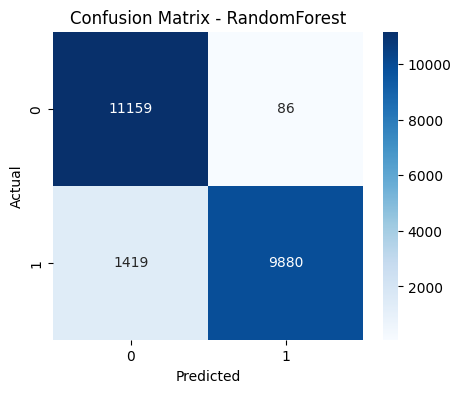

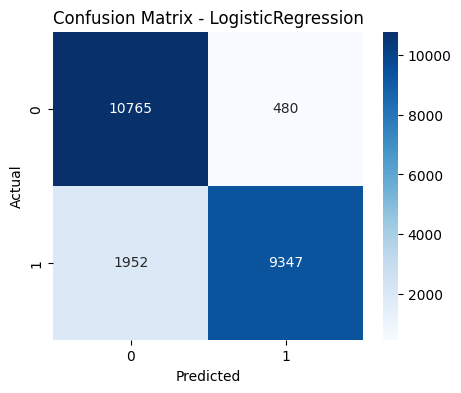

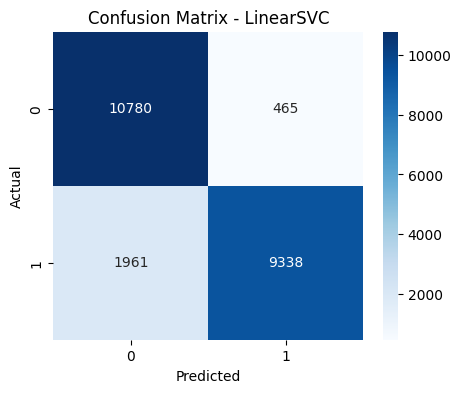

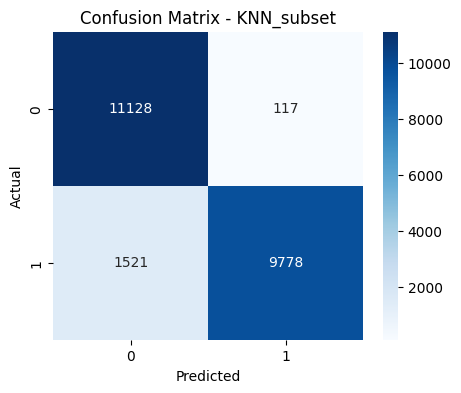

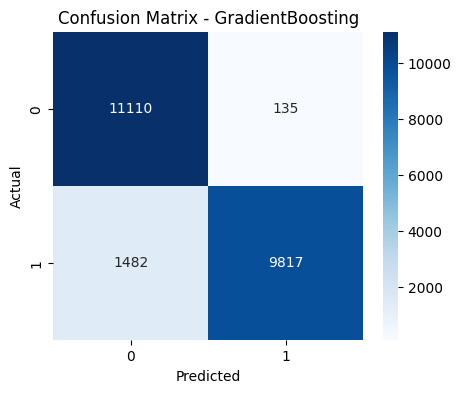

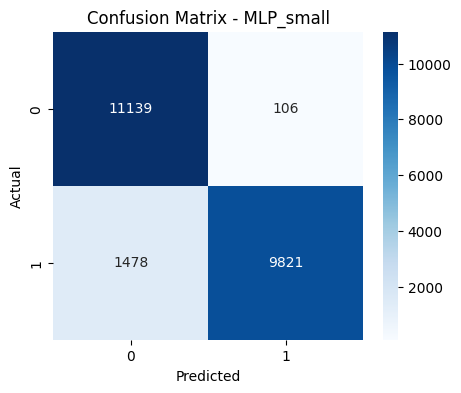

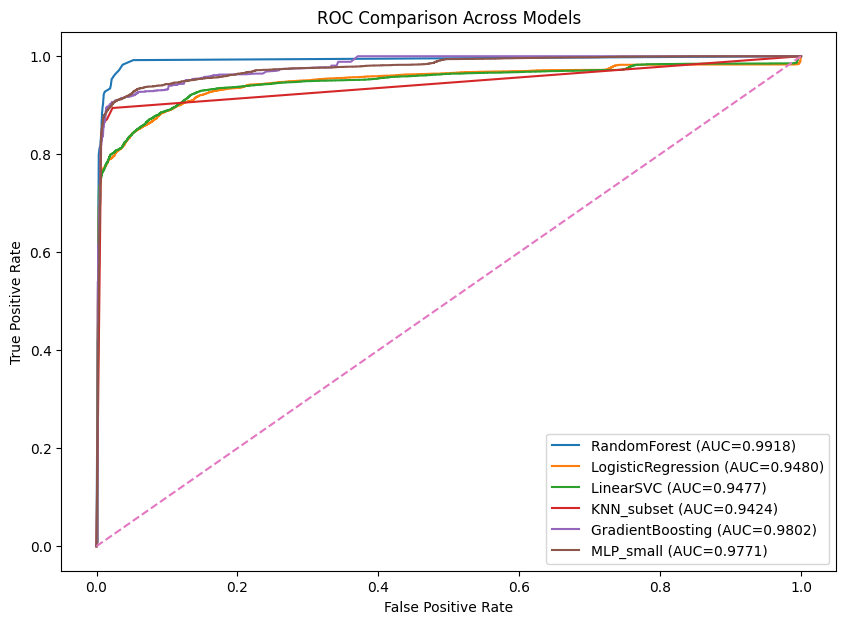

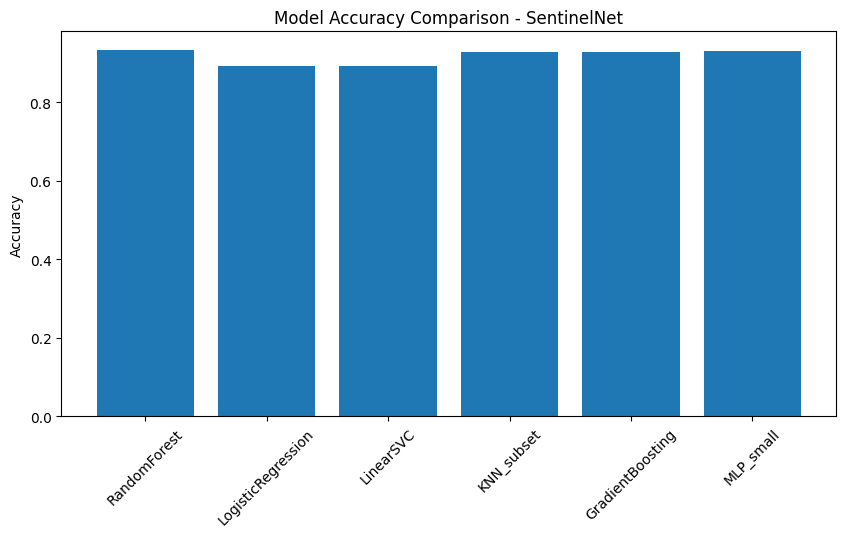

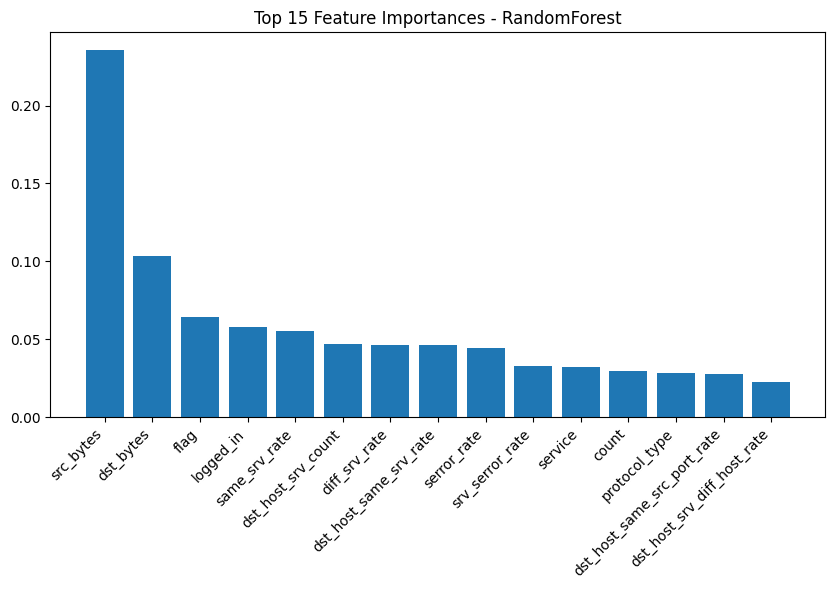



🎉 ALL MODELS TRAINED AND EVALUATED SUCCESSFULLY!


In [2]:
# ================================================
# SENTINELNET - COMPLETE NIDS MACHINE LEARNING PIPELINE
# Models included:
# RandomForest, Logistic Regression, LinearSVC, KNN (subset),
# GradientBoosting, MLP (small)
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------

df_train = pd.read_csv("kdd_train.csv")
df_test   = pd.read_csv("kdd_test.csv")

# Encode attack labels (normal = 0, attack = 1)
df_train["attack_binary"] = df_train["labels"].apply(lambda x: 0 if x=="normal" else 1)
df_test["attack_binary"]  = df_test["labels"].apply(lambda x: 0 if x=="normal" else 1)

df_train.drop(["labels"], axis=1, inplace=True)
df_test.drop(["labels"], axis=1, inplace=True)

# ---------------------------------------------------------
# 2. ENCODE CATEGORICAL COLUMNS
# ---------------------------------------------------------

cat_cols = ["protocol_type", "service", "flag"]
le = LabelEncoder()

for col in cat_cols:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col]  = le.transform(df_test[col])

# ---------------------------------------------------------
# 3. SEPARATE FEATURES AND TARGET
# ---------------------------------------------------------

X_train = df_train.drop("attack_binary", axis=1)
y_train = df_train["attack_binary"]

X_test  = df_test.drop("attack_binary", axis=1)
y_test  = df_test["attack_binary"]

# ---------------------------------------------------------
# 4. MISSING VALUE IMPUTATION
# ---------------------------------------------------------

imp = SimpleImputer(strategy="mean")
X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test_imp  = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

# ---------------------------------------------------------
# 5. FEATURE SCALING
# ---------------------------------------------------------

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_imp)
X_test_s  = scaler.transform(X_test_imp)

# ---------------------------------------------------------
# 6. DEFINE MODELS (SAFE FOR MEMORY)
# ---------------------------------------------------------

models = {
    "RandomForest": RandomForestClassifier(n_estimators=50, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVC": LinearSVC(max_iter=10000, dual=False),
    "KNN_subset": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=50),
    "MLP_small": MLPClassifier(hidden_layer_sizes=(32,16), max_iter=200)
}

results = {}

# ---------------------------------------------------------
# 7. TRAIN MODELS
# ---------------------------------------------------------

print("Training Machine Learning Models...\n")

subset_n = 20000
subset_idx = np.random.RandomState(42).choice(X_train_s.shape[0], size=subset_n, replace=False)

for name, model in models.items():

    print(f"\n==================== {name} ====================")

    # KNN only on subset
    if name == "KNN_subset":
        X_use = X_train_s[subset_idx]
        y_use = y_train.iloc[subset_idx]
    else:
        X_use = X_train_s
        y_use = y_train

    model.fit(X_use, y_use)

    # Predictions
    pred = model.predict(X_test_s)
    accuracy = accuracy_score(y_test, pred)
    report = classification_report(y_test, pred, output_dict=True)
    cm = confusion_matrix(y_test, pred)

    # ROC curve
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(X_test_s)[:,1]
    elif hasattr(model, "decision_function"):
        prob = model.decision_function(X_test_s)
        prob = (prob - prob.min())/(prob.max()-prob.min()+1e-12)
    else:
        prob = pred

    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)

    # Save
    results[name] = {
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": cm,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {roc_auc:.4f}")

# ---------------------------------------------------------
# 8. CONFUSION MATRICES
# ---------------------------------------------------------

for name in results:
    cm = results[name]["confusion_matrix"]
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# ---------------------------------------------------------
# 9. ROC CURVES FOR ALL MODELS
# ---------------------------------------------------------

plt.figure(figsize=(10,7))
for name in results:
    plt.plot(results[name]["fpr"], results[name]["tpr"],
             label=f"{name} (AUC={results[name]['roc_auc']:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison Across Models")
plt.legend()
plt.show()

# ---------------------------------------------------------
# 10. MODEL ACCURACY COMPARISON PLOT
# ---------------------------------------------------------

accs = {name: results[name]["accuracy"] for name in results}
plt.figure(figsize=(10,5))
plt.bar(accs.keys(), accs.values())
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison - SentinelNet")
plt.show()

# ---------------------------------------------------------
# 11. FEATURE IMPORTANCE (Random Forest)
# ---------------------------------------------------------

rf = models["RandomForest"]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10,5))
plt.bar([X_train.columns[i] for i in indices], importances[indices])
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Feature Importances - RandomForest")
plt.show()

print("\n\n🎉 ALL MODELS TRAINED AND EVALUATED SUCCESSFULLY!")
